In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import re

In [2]:
# Specify path to preprocessed dataset folder
preprocessed_dataset_path = 'D:\\MR-NIRP\\data\\PreprocessedData_driving_small_motion\\MR-NIRP_Raw_Raw_driving_small_motion'
# preprocessed_dataset_path = 'D:\\MR-NIRP\\data\\PreprocessedData_driving_still\\MR-NIRP_Raw_Raw_driving_still'
preprocessed_dataset_path = 'D:\\MR-NIRP\\data\\PreprocessedData_garage_small_motion\\MR-NIRP_Raw_Raw_garage_small_motion'
# preprocessed_dataset_path = 'D:\\MR-NIRP\\data\\PreprocessedData_garage_still\\MR-NIRP_Raw_Raw_garage_still'

In [3]:
# Check if the preprocessed dataset path is valid
# If valid, gather metadata

# Get a list of all input files in the preprocessed dataset folder
input_files = [filename for filename in os.listdir(preprocessed_dataset_path) if filename.endswith(".npy") and re.match(r".*input\d+\.npy", filename)]
label_files = []

# Check if each input file has a corresponding label file
isValid = True
for input_file in input_files:
    label_filename = input_file.replace("input", "label")
    if label_filename not in os.listdir(preprocessed_dataset_path):
        isValid = False
        print(f"Label file {label_filename} is missing for input file {input_file}!")
    else:
        label_files.append(label_filename)
if isValid == True:
    print(f"{len(input_files)} input chunks and {len(label_files)} label chunks detected.")
    # Extract SizeW value
    match_size_w = re.search(r"SizeW(\d+)", preprocessed_dataset_path)
    size_w = match_size_w.group(1) if match_size_w else None

    # Extract SizeH value
    match_size_h = re.search(r"SizeH(\d+)", preprocessed_dataset_path)
    size_h = match_size_h.group(1) if match_size_h else None

    # Extract ClipLength value
    match_clip_length = re.search(r"ClipLength(\d+)", preprocessed_dataset_path)
    clip_length = match_clip_length.group(1) if match_clip_length else None

    print(f"Preprocessed data has a width of {size_w}, height of {size_h}, and a clip length of {clip_length}.")
else:
    print("Preprocessed dataset is invalid! Please delete the preprocessed dataset folder and try to preprocess it again.")

35 input chunks and 35 label chunks detected.
Preprocessed data has a width of None, height of None, and a clip length of None.


The shape of the loaded label file is (3612,).


Dropdown(description='Chunk:', index=18, layout=Layout(width='800px'), options=('subject1_garage_small_motion_…

IntSlider(value=0, description='Frame:', layout=Layout(width='800px'), max=3626)

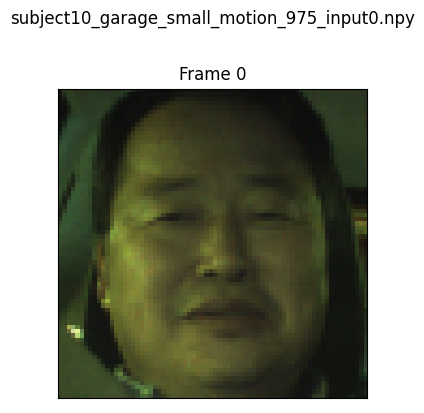

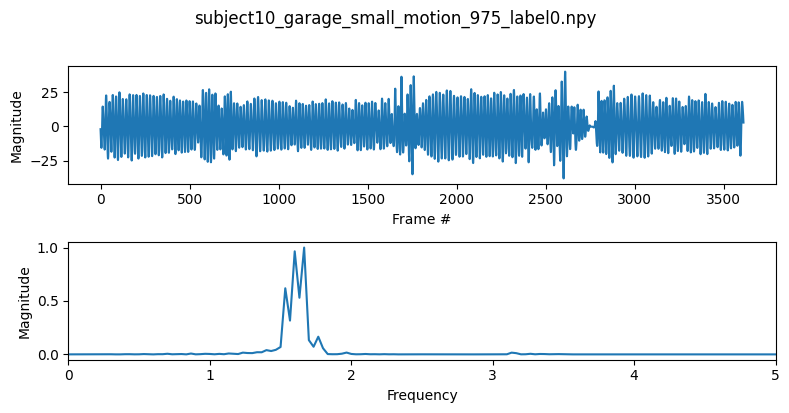

In [ ]:
# Cell to visualize RGB frames, diff normalized frames, and ground truth (label) after preprocessing
# Each visualization is done one chunk at a time
# !pip install natsort
# !pip install scipy
# !pip install ipywidgets

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from natsort import natsorted
import os
import scipy
from scipy.sparse import spdiags
from scipy.signal import butter
import math
from scipy import linalg
from scipy import signal
from scipy import sparse

class Visualizer:
    def __init__(self, preprocessed_dataset_path, input_files, label_files):
        self.input_files = natsorted(input_files)
        self.label_files = natsorted(label_files)
        self.chunk_dropdown = None
        self.fig = None
        self.ax = None
        self.frame_index_slider = None
        self.current_chunk_index = 0
        self.current_frame_index = 0
        self.dataset_path = preprocessed_dataset_path

        self.create_visualization()

    def create_visualization(self):
        self.create_dropdown()
        self.create_figure()
        self.create_slider()

    def create_dropdown(self):
        # Chunk dropdown
        self.chunk_dropdown = widgets.Dropdown(
            options=self.input_files,
            description='Chunk:',
            layout=widgets.Layout(width='800px'),
            value=None  # Set initial value to None
        )
        self.chunk_dropdown.observe(self.chunk_selection_changed, names='value')

        # Display dropdown
        display(self.chunk_dropdown)

    def create_figure(self):
        self.fig, self.ax = plt.subplots(figsize=(8, 4))
        self.fig.tight_layout()
        self.ax.set_xticks([])
        self.ax.set_yticks([])

    def create_slider(self):
        num_frames = self.get_num_frames()
        self.frame_index_slider = widgets.IntSlider(
            min=0,
            max=num_frames - 1,
            step=1,
            value=0,
            description='Frame:',
            layout=widgets.Layout(width='800px')
        )
        self.frame_index_slider.observe(self.frame_index_changed, names='value')

        # Display slider
        display(self.frame_index_slider)

    def chunk_selection_changed(self, change):
        selected_chunk = change.new
        self.current_chunk_index = self.input_files.index(selected_chunk)
        self.current_frame_index = 0
        self.frame_index_slider.value = 0
        self.update_frame()

    def frame_index_changed(self, change):
        self.current_frame_index = change.new
        self.update_frame()

    def get_num_frames(self):
        input_file = self.input_files[self.current_chunk_index]
        return np.load(os.path.join(self.dataset_path, input_file)).shape[0]

    def load_frame(self):
        input_file = self.input_files[self.current_chunk_index]
        input_data = np.load(os.path.join(self.dataset_path, input_file))
        print(f'The shape of the loaded chunk is {np.shape(input_data)}.')

        if input_data.shape[-1] == 6:
            rgb_frames = input_data[..., 3:]
            diff_normalized_frames = input_data[..., :3]

            # Create a side-by-side visualization
            frame = np.concatenate((rgb_frames, diff_normalized_frames), axis=2)
        elif input_data.shape[-1] == 3:
            # Use RGB frames directly for visualization
            frame = input_data
        else:
            raise ValueError("Invalid input_data shape. Expected shape (..., 3) or (..., 6).")

        return frame[self.current_frame_index]
    
    def create_label_figure(self):
        self.label_fig, (self.label_ax_time, self.label_ax_fft) = plt.subplots(2, 1, figsize=(8, 4))
        self.label_ax_time.set_xlabel('Frame #')
        self.label_ax_time.set_ylabel('Magnitude')
        self.label_ax_fft.set_xlabel('Frequency')
        self.label_ax_fft.set_ylabel('Magnitude')

    def update_label_frame(self):
        def _next_power_of_2(x):
            """Calculate the nearest power of 2."""
            return 1 if x == 0 else 2 ** (x - 1).bit_length()
        
        clear_output(wait=True)
        label_frame = self.load_label_frame()

        N = _next_power_of_2(label_frame.shape[0])
        fs = 30
        N = 30 * fs
        ppg_label_fft = label_frame
        ppg_label_f, ppg_label_pxx = scipy.signal.periodogram(ppg_label_fft, fs=fs, nfft=N, detrend=False)

        self.label_ax_time.clear()
        self.label_ax_fft.clear()

        self.label_ax_time.set_xlabel('Frame #')
        self.label_ax_time.set_ylabel('Magnitude')
        self.label_ax_time.plot(label_frame)

        self.label_ax_fft.set_xlabel('Frequency')
        self.label_ax_fft.set_ylabel('Magnitude')
        self.label_ax_fft.plot(ppg_label_f, ppg_label_pxx/ppg_label_pxx.max())

        self.label_ax_fft.set_xlim([0, 5])      # Set x-axis limits from 0 to 5 Hz

        self.label_fig.suptitle(self.label_files[self.current_chunk_index], y=1.02)
        self.label_fig.tight_layout()

    def load_label_frame(self):
        def _process_signal(signal):
            # Detrend and filter
            fs = 30
            diff_flag = False
            use_bandpass = True
            if diff_flag:  # if the predictions and labels are 1st derivative of PPG signal.
                gt_bvp = _detrend(np.cumsum(signal), 100)
            else:
                gt_bvp = _detrend(signal, 100)
            if use_bandpass:
                # bandpass filter between [0.75, 2.5] Hz
                # equals [45, 150] beats per min
                [b, a] = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
                signal = scipy.signal.filtfilt(b, a, np.double(signal))
            return signal


        def _detrend(input_signal, lambda_value):
            """Detrend PPG signal."""
            signal_length = input_signal.shape[0]
            # observation matrix
            H = np.identity(signal_length)
            ones = np.ones(signal_length)
            minus_twos = -2 * np.ones(signal_length)
            diags_data = np.array([ones, minus_twos, ones])
            diags_index = np.array([0, 1, 2])
            D = spdiags(diags_data, diags_index,
                        (signal_length - 2), signal_length).toarray()
            detrended_signal = np.dot(
                (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal)
            return detrended_signal
        
        label_file = self.label_files[self.current_chunk_index]
        label_data = np.load(os.path.join(self.dataset_path, label_file))
        print(f'The shape of the loaded label file is {np.shape(label_data)}.')

        label_data = _process_signal(label_data)

        return label_data

    def update_frame(self):
        clear_output(wait=True)
        frame = self.load_frame()

        # Clip frame to a valid range
        if np.issubdtype(frame.dtype, np.floating):
            frame = np.clip(frame, 0, 1)  # Clip float pixel values to [0, 1]
        elif np.issubdtype(frame.dtype, np.integer):
            frame = np.clip(frame, 0, 255)  # Clip integer pixel values to [0, 255]
        else:
            raise ValueError("Unsupported pixel value data type.")

        self.ax.imshow(frame)
        self.ax.set_title(f"Frame {self.current_frame_index}")
        self.fig.suptitle(self.input_files[self.current_chunk_index], y=1.02)
        self.fig.tight_layout()
        self.update_label_frame()
        display(self.chunk_dropdown, self.frame_index_slider, self.fig, self.label_fig)


# Create the visualizer instance
visualizer = Visualizer(preprocessed_dataset_path, input_files, label_files)

# Create the label figure
visualizer.create_label_figure()